In [1]:
%matplotlib inline

In [1]:
import re
import os
import codecs
import spacy
import sklearn
import numpy as np
import matplotlib.pyplot as plt
#from os import *
#import keras
#import pandas as pd
from sklearn import model_selection
from time import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.neighbors.nearest_centroid import NearestCentroid
from __future__ import unicode_literals

ModuleNotFoundError: No module named 'spacy'

In [30]:
nlp=spacy.load("en")

In [31]:
#infra_path = os.path.join("data", "error_classification", "tocheck.txt")
#infra_path = os.path.join("data", "error_classification", "sample.txt")
infra_path = os.path.join("data", "error_classification", "InfraRELATEDCHECK.txt")
user_path = os.path.join("data", "error_classification", "USERRELATEDCHECK1.txt")
 
infra_data = [l.strip() for l in codecs.open(infra_path, "r", "utf-8")]
user_data = [l.strip() for l in codecs.open(user_path, "r", "utf-8")]

#infra_data=codecs.open(infra_path,"r","utf-8")

errors = []
top3 = []
bot3 = []
cnt = 10
for line in infra_data:
    if "finished: failure" in line.lower():
        #Found new logfile delimiter
        errors.append((top3, bot3))
        top3 = []
        bot3 = []
    # In a log-file block, scan for errors
    if re.match(".*(error|fail(ure)?).*", line, re.I):
        #Error identified, adding it to the top3 or last3
        if (len(top3) < 10):
            top3.append(line)
        else:
        #Treat the bottom 3 as a stack of size 3
            if (len(bot3) >= 10):
                bot3.pop(1)
            bot3.append(line)
if (top3):
    #Need to attach last log sequence
    errors.append((top3, bot3))
    #print errors
    
    

#cnt = 0
#for (top3, bot3) in errors:
   # print "=== %d ===" % (cnt)
   # cnt+=1
   # print "--- Top 3: ---"
   # for l in top3:
       # print l
   # print "--- Bottom 3: ---"
   # for l in bot3:
       # print l
        
#user_data=codecs.open(user_path,"r","utf-8")

errors_user = []
top3 = []
bot3 = []
cnt = 10
for line in user_data:
    if "finished: failure" in line.lower():
        #Found new logfile delimiter
        errors_user.append((top3, bot3))
        top3 = []
        bot3 = []
    # In a log-file block, scan for errors
    if re.match(".*(error|fail(ure)?).*", line, re.I):
        #Error identified, adding it to the top3 or last3
        if (len(top3) < 10):
            top3.append(line)
        else:
        #Treat the bottom 3 as a stack of size 3
            if (len(bot3) >= 10):
                bot3.pop(1)
            bot3.append(line)
if (top3):
    #Need to attach last log sequence
    errors_user.append((top3, bot3))
    #print errors_user
#cnt = 0
#for (top3, bot3) in errors:
   # print "=== %d ===" % (cnt)
   # cnt+=1
   # print "--- Top 3: ---" 
   # for l in top3: 
   #    print l
   # print "--- Bottom 3: ---" 
   # for l in bot3: 
   #     print l
serialize=[]
for(top3, bot3) in errors:
    serialize.extend(top3)
    serialize.extend(bot3)
#print serialize
serialize2=[]
for(top3, bot3) in errors_user:
    serialize2.extend(top3)
    serialize2.extend(bot3)
corpus = serialize + serialize2
y = ([0] * len(serialize)) + ([1] * len(serialize2))
#print len(serialize2)



In [32]:
print("infra_data: \n",serialize[:2], "\n\n")

print("user_data: \n", serialize2[:2], "\n\n")

print("y: \n", y[:10], "\n\n", y[-10:], "\n\n")

print("Number of Infra Instances: {}\nNumber of User Instances: {}\n"
        "Size of Corpus: {}\nSize of y: {}".format(len(serialize), len(serialize2), 
                                              len(corpus), len(y)))

(u'infra_data: \n', [u'ERROR: WARNING: Failed to fetch Orca token (took 300 secs). ORCA_TOKEN variable will not be set.', u"03:19:17  ln: failed to create symbolic link `/nfs/imu/proj/opticm/tcloud.work5/musxtc6n2t009/opticm6/jenkins_workspace/workspace/_clean/xmm7660/development/utils/inway_project/../../testfwk/vp/login': No such file or directory"], u'\n\n')
(u'user_data: \n', [u'62668b3b855ef9f3903990244b1228fbc40961d7 Merge "during DCH to IDLE state transition, TRRC_PLMN_READY_IND is sent to NAS and cache_process should not be reset to INVALID [XMM7480][MK3_XG748ES1_S6TES2_DEV3][TDS][VER][CT-RRM][BEIJING][SP6210]:TC8.2.2.1_Fail_Timeout while waiting for SYNCH_UL on target cell" into xmm7480/development', u'2 - check that files are normalized according to gitattributes - NOT OK/FAIL'], u'\n\n')
(u'y: \n', [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], u'\n\n', [1, 1, 1, 1, 1, 1, 1, 1, 1, 1], u'\n\n')
Number of Infra Instances: 524
Number of User Instances: 580
Size of Corpus: 1104
Size of y: 1104

In [33]:
def stratified_split(X, y, n_splits=10, test_size=0.2):
    skf = StratifiedShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=0)
    skf.get_n_splits(X, y)
    splits = []
    for train_index, test_index in skf.split(X, y):
        print("TRAIN:", train_index, "\n\n", "TEST:", test_index, "\n\n")
        X_train, X_test = [X[i] for i in train_index], [X[i] for i in test_index]
        y_train, y_test = [y[i] for i in train_index], [y[i] for i in test_index]
        splits.append({"train": {"X": X_train, "y": y_train},
                       "test": {"X": X_test, "y": y_test}})
    return splits
#print X_train[1]

In [34]:
def tokenize(doc):
    """
    Returns a list of strings containing each token in `sentence`
    """
    #return [i for i in re.split(r"([-.\"',:? !\$#@~()*&\^%;\[\]/\\\+<>\n=])",
    #                            doc) if i != '' and i != ' ' and i != '\n']
    tokens = []
    doc = nlp.tokenizer(doc)
    for token in doc:
        #print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_,
        #      token.shape_, token.is_alpha, token.is_stop)
        #if not token.is_stop:
        #    clean_tokens.append(token.lemma_)
        tokens.append(token.text)
    return tokens


def preprocess(doc):
    clean_tokens = []
    doc = nlp(doc)
    for token in doc:
        #print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_,
        #      token.shape_, token.is_alpha, token.is_stop)
        if not token.is_stop:
            clean_tokens.append(token.lemma_)
        #clean_tokens.append(token.lemma_)
    return " ".join(clean_tokens)

In [35]:
clean_doc = preprocess("I was flying a kite when the man in the blue shirt tried to steal my wallet")
print(clean_doc)
#type(clean_doc)

fly kite man blue shirt try steal wallet


In [36]:
tokens_from_clean_text = tokenize(clean_doc)
print(tokens_from_clean_text)
#type(tokens_from_clean_text)

[u'fly', u'kite', u'man', u'blue', u'shirt', u'try', u'steal', u'wallet']


In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [38]:
def get_vectorizer(corpus, preprocessor=None, tokenizer=None):
    vectorizer = TfidfVectorizer(norm='l2',min_df=0, use_idf=True, smooth_idf=False,#analyzer='word',
                                 ngram_range=(3,3),analyzer='char',
                                       sublinear_tf=True, preprocessor=preprocessor, tokenizer=tokenizer)
    vectorizer.fit(corpus)
    return vectorizer, vectorizer.get_feature_names()

In [39]:
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.utils.extmath import density
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
#from sklearn.cross_validation import cross_val_score

In [40]:
def trim(s):
    """Trim string to fit on terminal (assuming 80-column display)"""
    return s if len(s) <= 80 else s[:77] + "..."


# #############################################################################
# Benchmark classifiers
def benchmark(clf, X_train, y_train, X_test, y_test, target_names,
              print_report=True, feature_names=None, print_top10=False,
              print_cm=True):
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % score)
    #print("Accuracy: %0.3f (+/- %0.3f)" % (score.mean(), score.std() * 2))

    if hasattr(clf, 'coef_'):
        print("dimensionality: %d" % clf.coef_.shape[1])
        print("density: %f" % density(clf.coef_))

        if print_top10 and feature_names is not None:
            print("top 10 keywords per class:")
            for i, label in enumerate(["infra", "user"]):
                top10 = np.argsort(clf.coef_[i])[-10:]
                print(trim("%s: %s" % (label, " ".join([feature_names[i] for i in top10]))))
        print()

    if print_report:
        print("classification report:")
        print(metrics.classification_report(y_test, pred,
                                            target_names=target_names))

    if print_cm:
        print("confusion matrix:")
        print(metrics.confusion_matrix(y_test, pred))

    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time
    #avg=cross_val_score(clf,corpus,y,cv=5)
#print avg

In [41]:
def plot_results(results):
    # make some plots
    indices = np.arange(len(results))

    results = [[x[i] for x in results] for i in range(4)]

    clf_names, score, training_time, test_time = results
    training_time = np.array(training_time) / np.max(training_time)
    test_time = np.array(test_time) / np.max(test_time)

    plt.figure(figsize=(12, 8))
    plt.title("Score")
    plt.barh(indices, score, .2, label="score", color='navy')
    plt.barh(indices + .3, training_time, .2, label="training time",
             color='c')
    plt.barh(indices + .6, test_time, .2, label="test time", color='darkorange')
    plt.yticks(())
    plt.legend(loc='best')
    plt.subplots_adjust(left=.25)
    plt.subplots_adjust(top=.95)
    plt.subplots_adjust(bottom=.05)

    for i, c in zip(indices, clf_names):
        plt.text(-.3, i, c)

    plt.show()

In [42]:
def get_X_andy_from_split(split):
    train_corpus, y_train = split["train"]["X"], split["train"]["y"]
    test_corpus, y_test = split["test"]["X"], split["test"]["y"]
    vectorizer, feature_names = get_vectorizer(train_corpus, preprocessor=preprocess, tokenizer=tokenize)
    X_train = vectorizer.transform(train_corpus).toarray()
    X_test = vectorizer.transform(test_corpus).toarray()
    return X_train, y_train, X_test, y_test, feature_names
#print feature_names



In [43]:
splits = stratified_split(corpus, y, n_splits=10, test_size=0.2)

(u'TRAIN:', array([ 383,  237,  921,  923,  978,  355,  859,  626,  204,  249,   68,
        466,    2,   81,  974,  812,  763, 1050,  959, 1058,  437,  280,
        680,  525,  564,  600,  609,  955,  756,  173, 1089,  535,  228,
         78,  914,  927,  821,  523,  660,  714,  411,  651,  457,  205,
        741, 1001,  462,  217,   52,  229,  347, 1010,  308, 1034,  490,
        377,  727,   27,  754,  614,  595,  405,  153,  218,  284,  647,
        152,  998,  792,  474,   61,  765,  536,  988,   83, 1035,  415,
         14,  116,  548,  817,  332,  504,  346,  865,  315,  351,  168,
        848,  419,  491,  674,   59,  497,  720, 1060,   25,  302,  367,
        136,  142, 1030,  539,  683,  200,  929,  832,   92,  715,  759,
        270,  894,   63, 1045,  627, 1084, 1075,   12,  752,  159,  887,
        113,  353,  312,  746,  861,  433,  230, 1053,  438,  554,  293,
         85,  186,  896,  555,  410,  139, 1017,   17, 1054,  879,  140,
        601,  144,  850,  166,   97,  8

Evaluating Split 0
Train Size: 883
Test Size: 221
Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver=u'lsqr',
        tol=0.01)
train time: 0.180s
test time:  0.004s
accuracy:   0.814
dimensionality: 9912
density: 1.000000
()
classification report:
             precision    recall  f1-score   support

      infra       0.81      0.79      0.80       105
       user       0.82      0.84      0.83       116

avg / total       0.81      0.81      0.81       221

confusion matrix:
[[83 22]
 [19 97]]
()
gridsearchknn
________________________________________________________________________________
Training: 
GridSearchCV(cv=10, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, 

/nfs/site/home/kputtas1/instance/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 1.162s
test time:  0.003s
accuracy:   0.787
dimensionality: 9912
density: 0.993140
()
classification report:
             precision    recall  f1-score   support

      infra       0.83      0.70      0.76       105
       user       0.76      0.87      0.81       116

avg / total       0.79      0.79      0.79       221

confusion matrix:
[[ 73  32]
 [ 15 101]]
()
gridsearchRF
________________________________________________________________________________
Training: 
GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n

/nfs/site/home/kputtas1/instance/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.771s
test time:  0.003s
accuracy:   0.824
dimensionality: 9912
density: 0.988196
()
classification report:
             precision    recall  f1-score   support

      infra       0.82      0.81      0.81       105
       user       0.83      0.84      0.83       116

avg / total       0.82      0.82      0.82       221

confusion matrix:
[[85 20]
 [19 97]]
()
L1 penalty
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty=u'l1', random_state=None, tol=0.001,
     verbose=0)
train time: 0.070s
test time:  0.004s
accuracy:   0.792
dimensionality: 9912
density: 0.014931
()
classification report:
             precision    recall  f1-score   support

      infra       0.80      0.74      0.77       105
       user       0.78      0.84      0.81       116

avg / total       0.79 

/nfs/site/home/kputtas1/instance/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 2.832s
test time:  0.003s
accuracy:   0.796
dimensionality: 9912
density: 0.085956
()
classification report:
             precision    recall  f1-score   support

      infra       0.76      0.84      0.80       105
       user       0.84      0.76      0.80       116

avg / total       0.80      0.80      0.80       221

confusion matrix:
[[88 17]
 [28 88]]
()
Elastic-Net penalty
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=50,
       n_jobs=1, penalty=u'elasticnet', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)


/nfs/site/home/kputtas1/instance/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 5.029s
test time:  0.003s
accuracy:   0.824
dimensionality: 9912
density: 0.516848
()
classification report:
             precision    recall  f1-score   support

      infra       0.83      0.79      0.81       105
       user       0.82      0.85      0.84       116

avg / total       0.82      0.82      0.82       221

confusion matrix:
[[83 22]
 [17 99]]
()
NearestCentroid (aka Rocchio classifier)
________________________________________________________________________________
Training: 
NearestCentroid(metric='euclidean', shrink_threshold=None)
train time: 0.046s
test time:  0.014s
accuracy:   0.747
classification report:
             precision    recall  f1-score   support

      infra       0.72      0.77      0.74       105
       user       0.78      0.72      0.75       116

avg / total       0.75      0.75      0.75       221

confusion matrix:
[[81 24]
 [32 84]]
()
Naive Bayes
________________________________________________________________________________
Train

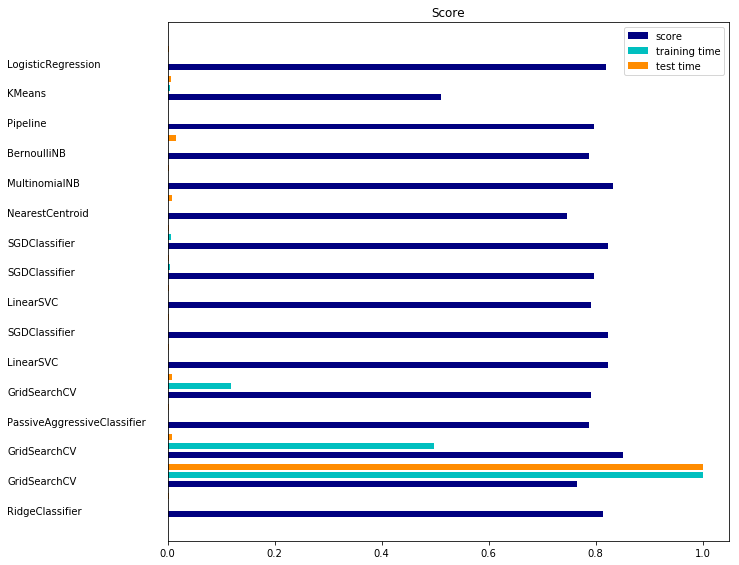

Evaluating Split 1
Train Size: 883
Test Size: 221
Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver=u'lsqr',
        tol=0.01)
train time: 0.187s
test time:  0.004s
accuracy:   0.851
dimensionality: 10215
density: 1.000000
()
classification report:
             precision    recall  f1-score   support

      infra       0.89      0.78      0.83       105
       user       0.82      0.91      0.87       116

avg / total       0.85      0.85      0.85       221

confusion matrix:
[[ 82  23]
 [ 10 106]]
()
gridsearchknn
________________________________________________________________________________
Training: 
GridSearchCV(cv=10, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbor

/nfs/site/home/kputtas1/instance/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 1.207s
test time:  0.004s
accuracy:   0.819
dimensionality: 10215
density: 0.994126
()
classification report:
             precision    recall  f1-score   support

      infra       0.77      0.89      0.82       105
       user       0.88      0.76      0.81       116

avg / total       0.83      0.82      0.82       221

confusion matrix:
[[93 12]
 [28 88]]
()
gridsearchRF
________________________________________________________________________________
Training: 
GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jo

/nfs/site/home/kputtas1/instance/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.798s
test time:  0.003s
accuracy:   0.833
dimensionality: 10215
density: 0.990798
()
classification report:
             precision    recall  f1-score   support

      infra       0.89      0.74      0.81       105
       user       0.80      0.91      0.85       116

avg / total       0.84      0.83      0.83       221

confusion matrix:
[[ 78  27]
 [ 10 106]]
()
L1 penalty
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty=u'l1', random_state=None, tol=0.001,
     verbose=0)
train time: 0.068s
test time:  0.004s
accuracy:   0.810
dimensionality: 10215
density: 0.014684
()
classification report:
             precision    recall  f1-score   support

      infra       0.85      0.72      0.78       105
       user       0.78      0.89      0.83       116

avg / total      

/nfs/site/home/kputtas1/instance/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 2.933s
test time:  0.003s
accuracy:   0.833
dimensionality: 10215
density: 0.090847
()
classification report:
             precision    recall  f1-score   support

      infra       0.86      0.77      0.81       105
       user       0.81      0.89      0.85       116

avg / total       0.84      0.83      0.83       221

confusion matrix:
[[ 81  24]
 [ 13 103]]
()
Elastic-Net penalty
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=50,
       n_jobs=1, penalty=u'elasticnet', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)


/nfs/site/home/kputtas1/instance/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 5.111s
test time:  0.003s
accuracy:   0.819
dimensionality: 10215
density: 0.484581
()
classification report:
             precision    recall  f1-score   support

      infra       0.86      0.74      0.80       105
       user       0.79      0.89      0.84       116

avg / total       0.82      0.82      0.82       221

confusion matrix:
[[ 78  27]
 [ 13 103]]
()
NearestCentroid (aka Rocchio classifier)
________________________________________________________________________________
Training: 
NearestCentroid(metric='euclidean', shrink_threshold=None)
train time: 0.039s
test time:  0.015s
accuracy:   0.792
classification report:
             precision    recall  f1-score   support

      infra       0.79      0.76      0.78       105
       user       0.79      0.82      0.81       116

avg / total       0.79      0.79      0.79       221

confusion matrix:
[[80 25]
 [21 95]]
()
Naive Bayes
________________________________________________________________________________


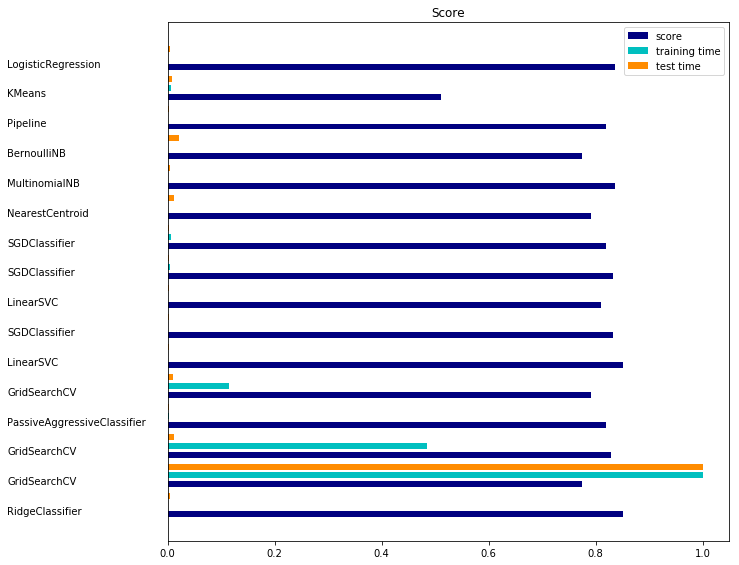

Evaluating Split 2
Train Size: 883
Test Size: 221
Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver=u'lsqr',
        tol=0.01)
train time: 0.179s
test time:  0.004s
accuracy:   0.814
dimensionality: 9922
density: 1.000000
()
classification report:
             precision    recall  f1-score   support

      infra       0.84      0.75      0.79       105
       user       0.80      0.87      0.83       116

avg / total       0.82      0.81      0.81       221

confusion matrix:
[[ 79  26]
 [ 15 101]]
()
gridsearchknn
________________________________________________________________________________
Training: 
GridSearchCV(cv=10, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors

/nfs/site/home/kputtas1/instance/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 1.252s
test time:  0.005s
accuracy:   0.801
dimensionality: 9922
density: 0.987906
()
classification report:
             precision    recall  f1-score   support

      infra       0.75      0.88      0.81       105
       user       0.87      0.73      0.79       116

avg / total       0.81      0.80      0.80       221

confusion matrix:
[[92 13]
 [31 85]]
()
gridsearchRF
________________________________________________________________________________
Training: 
GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_job

/nfs/site/home/kputtas1/instance/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.860s
test time:  0.003s
accuracy:   0.805
dimensionality: 9922
density: 0.988510
()
classification report:
             precision    recall  f1-score   support

      infra       0.78      0.82      0.80       105
       user       0.83      0.79      0.81       116

avg / total       0.81      0.81      0.81       221

confusion matrix:
[[86 19]
 [24 92]]
()
L1 penalty
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty=u'l1', random_state=None, tol=0.001,
     verbose=0)
train time: 0.073s
test time:  0.004s
accuracy:   0.792
dimensionality: 9922
density: 0.015521
()
classification report:
             precision    recall  f1-score   support

      infra       0.84      0.70      0.76       105
       user       0.76      0.88      0.82       116

avg / total       0.80 

/nfs/site/home/kputtas1/instance/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 4.364s
test time:  0.006s
accuracy:   0.824
dimensionality: 9922
density: 0.087684
()
classification report:
             precision    recall  f1-score   support

      infra       0.86      0.75      0.80       105
       user       0.80      0.89      0.84       116

avg / total       0.83      0.82      0.82       221

confusion matrix:
[[ 79  26]
 [ 13 103]]
()
Elastic-Net penalty
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=50,
       n_jobs=1, penalty=u'elasticnet', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)


/nfs/site/home/kputtas1/instance/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 7.679s
test time:  0.022s
accuracy:   0.814
dimensionality: 9922
density: 0.496271
()
classification report:
             precision    recall  f1-score   support

      infra       0.86      0.72      0.79       105
       user       0.78      0.90      0.84       116

avg / total       0.82      0.81      0.81       221

confusion matrix:
[[ 76  29]
 [ 12 104]]
()
NearestCentroid (aka Rocchio classifier)
________________________________________________________________________________
Training: 
NearestCentroid(metric='euclidean', shrink_threshold=None)
train time: 0.106s
test time:  0.016s
accuracy:   0.738
classification report:
             precision    recall  f1-score   support

      infra       0.68      0.84      0.75       105
       user       0.82      0.65      0.72       116

avg / total       0.75      0.74      0.74       221

confusion matrix:
[[88 17]
 [41 75]]
()
Naive Bayes
________________________________________________________________________________
T

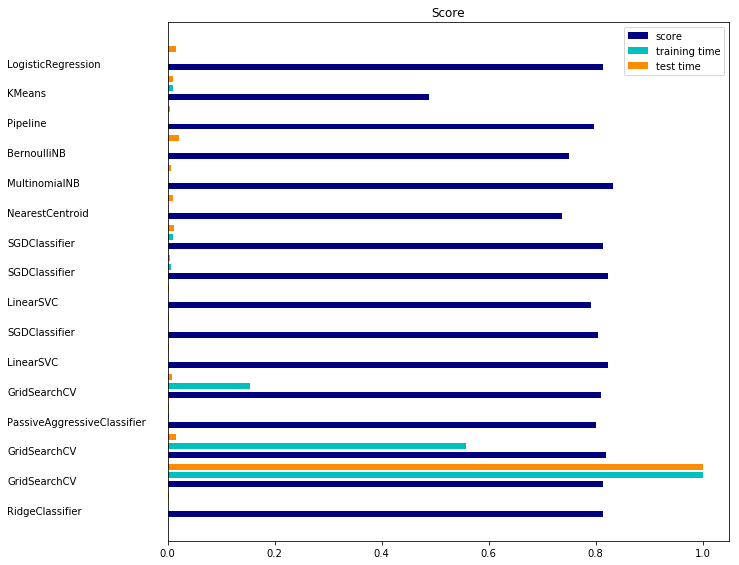

Evaluating Split 3
Train Size: 883
Test Size: 221
Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver=u'lsqr',
        tol=0.01)
train time: 0.269s
test time:  0.017s
accuracy:   0.842
dimensionality: 10193
density: 1.000000
()
classification report:
             precision    recall  f1-score   support

      infra       0.86      0.80      0.83       105
       user       0.83      0.88      0.85       116

avg / total       0.84      0.84      0.84       221

confusion matrix:
[[ 84  21]
 [ 14 102]]
()
gridsearchknn
________________________________________________________________________________
Training: 
GridSearchCV(cv=10, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbor

/nfs/site/home/kputtas1/instance/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 1.214s
test time:  0.004s
accuracy:   0.828
dimensionality: 10193
density: 0.988816
()
classification report:
             precision    recall  f1-score   support

      infra       0.77      0.90      0.83       105
       user       0.90      0.76      0.82       116

avg / total       0.84      0.83      0.83       221

confusion matrix:
[[95 10]
 [28 88]]
()
gridsearchRF
________________________________________________________________________________
Training: 
GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jo

/nfs/site/home/kputtas1/instance/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.811s
test time:  0.004s
accuracy:   0.828
dimensionality: 10193
density: 0.987540
()
classification report:
             precision    recall  f1-score   support

      infra       0.85      0.77      0.81       105
       user       0.81      0.88      0.84       116

avg / total       0.83      0.83      0.83       221

confusion matrix:
[[ 81  24]
 [ 14 102]]
()
L1 penalty
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty=u'l1', random_state=None, tol=0.001,
     verbose=0)
train time: 0.067s
test time:  0.004s
accuracy:   0.819
dimensionality: 10193
density: 0.014520
()
classification report:
             precision    recall  f1-score   support

      infra       0.84      0.77      0.80       105
       user       0.81      0.86      0.83       116

avg / total      

/nfs/site/home/kputtas1/instance/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 2.969s
test time:  0.004s
accuracy:   0.837
dimensionality: 10193
density: 0.092613
()
classification report:
             precision    recall  f1-score   support

      infra       0.78      0.91      0.84       105
       user       0.91      0.77      0.83       116

avg / total       0.85      0.84      0.84       221

confusion matrix:
[[96  9]
 [27 89]]
()
Elastic-Net penalty
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=50,
       n_jobs=1, penalty=u'elasticnet', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)


/nfs/site/home/kputtas1/instance/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 5.155s
test time:  0.004s
accuracy:   0.828
dimensionality: 10193
density: 0.498872
()
classification report:
             precision    recall  f1-score   support

      infra       0.79      0.88      0.83       105
       user       0.88      0.78      0.83       116

avg / total       0.83      0.83      0.83       221

confusion matrix:
[[92 13]
 [25 91]]
()
NearestCentroid (aka Rocchio classifier)
________________________________________________________________________________
Training: 
NearestCentroid(metric='euclidean', shrink_threshold=None)
train time: 0.067s
test time:  0.016s
accuracy:   0.724
classification report:
             precision    recall  f1-score   support

      infra       0.69      0.76      0.72       105
       user       0.76      0.69      0.72       116

avg / total       0.73      0.72      0.72       221

confusion matrix:
[[80 25]
 [36 80]]
()
Naive Bayes
________________________________________________________________________________
Trai

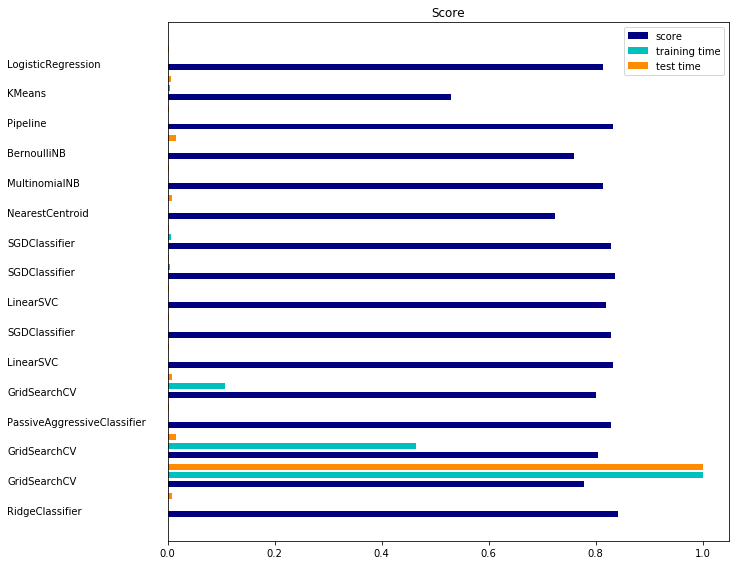

Evaluating Split 4
Train Size: 883
Test Size: 221
Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver=u'lsqr',
        tol=0.01)
train time: 0.189s
test time:  0.004s
accuracy:   0.805
dimensionality: 10315
density: 1.000000
()
classification report:
             precision    recall  f1-score   support

      infra       0.78      0.82      0.80       105
       user       0.83      0.79      0.81       116

avg / total       0.81      0.81      0.81       221

confusion matrix:
[[86 19]
 [24 92]]
()
gridsearchknn
________________________________________________________________________________
Training: 
GridSearchCV(cv=10, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5,

/nfs/site/home/kputtas1/instance/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 1.298s
test time:  0.003s
accuracy:   0.814
dimensionality: 10315
density: 0.995734
()
classification report:
             precision    recall  f1-score   support

      infra       0.84      0.75      0.79       105
       user       0.80      0.87      0.83       116

avg / total       0.82      0.81      0.81       221

confusion matrix:
[[ 79  26]
 [ 15 101]]
()
gridsearchRF
________________________________________________________________________________
Training: 
GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, 

/nfs/site/home/kputtas1/instance/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.903s
test time:  0.003s
accuracy:   0.819
dimensionality: 10315
density: 0.987688
()
classification report:
             precision    recall  f1-score   support

      infra       0.80      0.83      0.81       105
       user       0.84      0.81      0.82       116

avg / total       0.82      0.82      0.82       221

confusion matrix:
[[87 18]
 [22 94]]
()
L1 penalty
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty=u'l1', random_state=None, tol=0.001,
     verbose=0)
train time: 0.065s
test time:  0.004s
accuracy:   0.778
dimensionality: 10315
density: 0.013669
()
classification report:
             precision    recall  f1-score   support

      infra       0.75      0.79      0.77       105
       user       0.80      0.77      0.78       116

avg / total       0.7

/nfs/site/home/kputtas1/instance/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 3.066s
test time:  0.003s
accuracy:   0.796
dimensionality: 10315
density: 0.090160
()
classification report:
             precision    recall  f1-score   support

      infra       0.77      0.81      0.79       105
       user       0.82      0.78      0.80       116

avg / total       0.80      0.80      0.80       221

confusion matrix:
[[85 20]
 [25 91]]
()
Elastic-Net penalty
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=50,
       n_jobs=1, penalty=u'elasticnet', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)


/nfs/site/home/kputtas1/instance/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 5.267s
test time:  0.003s
accuracy:   0.742
dimensionality: 10315
density: 0.487349
()
classification report:
             precision    recall  f1-score   support

      infra       0.65      0.97      0.78       105
       user       0.95      0.53      0.69       116

avg / total       0.81      0.74      0.73       221

confusion matrix:
[[102   3]
 [ 54  62]]
()
NearestCentroid (aka Rocchio classifier)
________________________________________________________________________________
Training: 
NearestCentroid(metric='euclidean', shrink_threshold=None)
train time: 0.051s
test time:  0.015s
accuracy:   0.747
classification report:
             precision    recall  f1-score   support

      infra       0.72      0.75      0.74       105
       user       0.77      0.74      0.75       116

avg / total       0.75      0.75      0.75       221

confusion matrix:
[[79 26]
 [30 86]]
()
Naive Bayes
________________________________________________________________________________


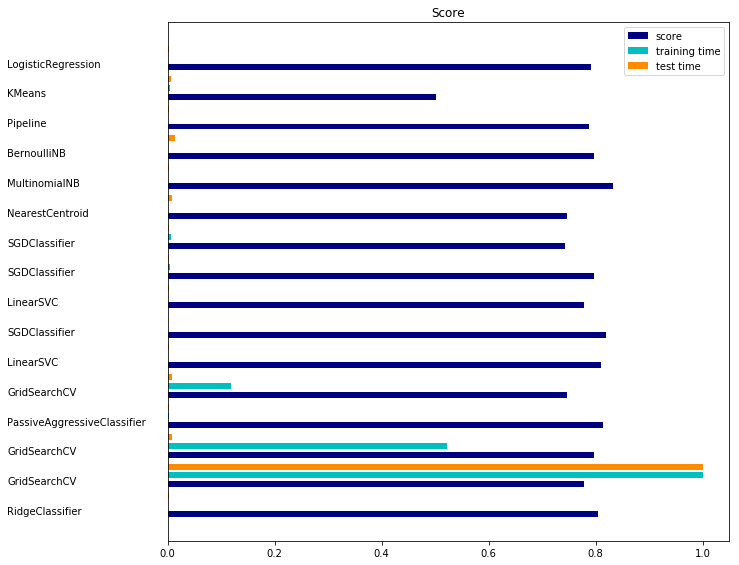

Evaluating Split 5
Train Size: 883
Test Size: 221
Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver=u'lsqr',
        tol=0.01)
train time: 0.183s
test time:  0.004s
accuracy:   0.846
dimensionality: 10106
density: 1.000000
()
classification report:
             precision    recall  f1-score   support

      infra       0.88      0.78      0.83       105
       user       0.82      0.91      0.86       116

avg / total       0.85      0.85      0.85       221

confusion matrix:
[[ 82  23]
 [ 11 105]]
()
gridsearchknn
________________________________________________________________________________
Training: 
GridSearchCV(cv=10, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbor

/nfs/site/home/kputtas1/instance/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 1.190s
test time:  0.003s
accuracy:   0.756
dimensionality: 10106
density: 0.992282
()
classification report:
             precision    recall  f1-score   support

      infra       0.69      0.90      0.78       105
       user       0.87      0.63      0.73       116

avg / total       0.78      0.76      0.75       221

confusion matrix:
[[94 11]
 [43 73]]
()
gridsearchRF
________________________________________________________________________________
Training: 
GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jo

/nfs/site/home/kputtas1/instance/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.795s
test time:  0.003s
accuracy:   0.792
dimensionality: 10106
density: 0.991193
()
classification report:
             precision    recall  f1-score   support

      infra       0.75      0.84      0.79       105
       user       0.84      0.75      0.79       116

avg / total       0.80      0.79      0.79       221

confusion matrix:
[[88 17]
 [29 87]]
()
L1 penalty
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty=u'l1', random_state=None, tol=0.001,
     verbose=0)
train time: 0.070s
test time:  0.004s
accuracy:   0.792
dimensionality: 10106
density: 0.015238
()
classification report:
             precision    recall  f1-score   support

      infra       0.84      0.70      0.76       105
       user       0.76      0.88      0.82       116

avg / total       0.8

/nfs/site/home/kputtas1/instance/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 2.893s
test time:  0.003s
accuracy:   0.810
dimensionality: 10106
density: 0.088264
()
classification report:
             precision    recall  f1-score   support

      infra       0.83      0.75      0.79       105
       user       0.79      0.86      0.83       116

avg / total       0.81      0.81      0.81       221

confusion matrix:
[[ 79  26]
 [ 16 100]]
()
Elastic-Net penalty
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=50,
       n_jobs=1, penalty=u'elasticnet', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)


/nfs/site/home/kputtas1/instance/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 5.146s
test time:  0.003s
accuracy:   0.801
dimensionality: 10106
density: 0.525529
()
classification report:
             precision    recall  f1-score   support

      infra       0.87      0.69      0.77       105
       user       0.76      0.91      0.83       116

avg / total       0.81      0.80      0.80       221

confusion matrix:
[[ 72  33]
 [ 11 105]]
()
NearestCentroid (aka Rocchio classifier)
________________________________________________________________________________
Training: 
NearestCentroid(metric='euclidean', shrink_threshold=None)
train time: 0.045s
test time:  0.014s
accuracy:   0.751
classification report:
             precision    recall  f1-score   support

      infra       0.71      0.81      0.76       105
       user       0.80      0.70      0.75       116

avg / total       0.76      0.75      0.75       221

confusion matrix:
[[85 20]
 [35 81]]
()
Naive Bayes
________________________________________________________________________________


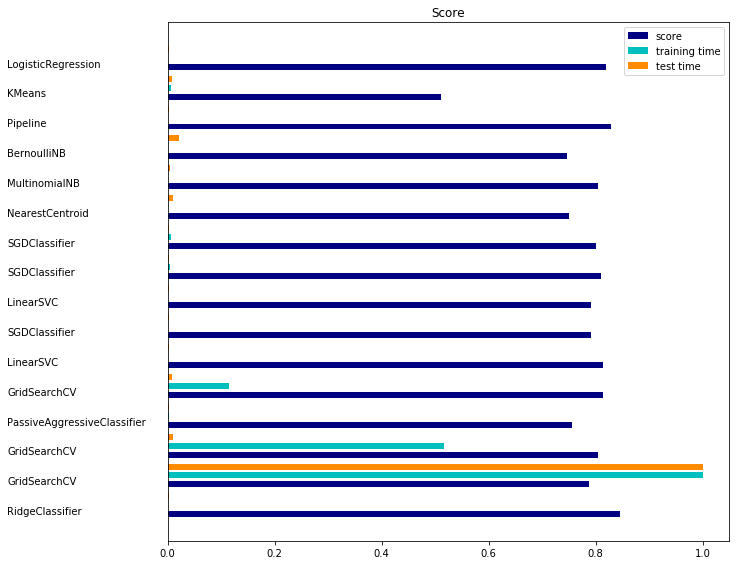

Evaluating Split 6
Train Size: 883
Test Size: 221
Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver=u'lsqr',
        tol=0.01)
train time: 0.151s
test time:  0.003s
accuracy:   0.805
dimensionality: 8184
density: 1.000000
()
classification report:
             precision    recall  f1-score   support

      infra       0.88      0.69      0.77       105
       user       0.76      0.91      0.83       116

avg / total       0.82      0.81      0.80       221

confusion matrix:
[[ 72  33]
 [ 10 106]]
()
gridsearchknn
________________________________________________________________________________
Training: 
GridSearchCV(cv=10, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors

/nfs/site/home/kputtas1/instance/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 1.032s
test time:  0.003s
accuracy:   0.810
dimensionality: 8184
density: 0.979350
()
classification report:
             precision    recall  f1-score   support

      infra       0.86      0.71      0.78       105
       user       0.78      0.90      0.83       116

avg / total       0.82      0.81      0.81       221

confusion matrix:
[[ 75  30]
 [ 12 104]]
()
gridsearchRF
________________________________________________________________________________
Training: 
GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n

/nfs/site/home/kputtas1/instance/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.708s
test time:  0.003s
accuracy:   0.814
dimensionality: 8184
density: 0.985582
()
classification report:
             precision    recall  f1-score   support

      infra       0.89      0.70      0.78       105
       user       0.77      0.92      0.84       116

avg / total       0.83      0.81      0.81       221

confusion matrix:
[[ 73  32]
 [  9 107]]
()
L1 penalty
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty=u'l1', random_state=None, tol=0.001,
     verbose=0)
train time: 0.057s
test time:  0.003s
accuracy:   0.805
dimensionality: 8184
density: 0.018328
()
classification report:
             precision    recall  f1-score   support

      infra       0.87      0.70      0.77       105
       user       0.77      0.91      0.83       116

avg / total       0

/nfs/site/home/kputtas1/instance/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 2.591s
test time:  0.002s
accuracy:   0.851
dimensionality: 8184
density: 0.107771
()
classification report:
             precision    recall  f1-score   support

      infra       0.86      0.82      0.84       105
       user       0.84      0.88      0.86       116

avg / total       0.85      0.85      0.85       221

confusion matrix:
[[ 86  19]
 [ 14 102]]
()
Elastic-Net penalty
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=50,
       n_jobs=1, penalty=u'elasticnet', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)


/nfs/site/home/kputtas1/instance/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 4.355s
test time:  0.002s
accuracy:   0.810
dimensionality: 8184
density: 0.632331
()
classification report:
             precision    recall  f1-score   support

      infra       0.89      0.69      0.77       105
       user       0.76      0.92      0.84       116

avg / total       0.82      0.81      0.81       221

confusion matrix:
[[ 72  33]
 [  9 107]]
()
NearestCentroid (aka Rocchio classifier)
________________________________________________________________________________
Training: 
NearestCentroid(metric='euclidean', shrink_threshold=None)
train time: 0.034s
test time:  0.012s
accuracy:   0.787
classification report:
             precision    recall  f1-score   support

      infra       0.80      0.74      0.77       105
       user       0.78      0.83      0.80       116

avg / total       0.79      0.79      0.79       221

confusion matrix:
[[78 27]
 [20 96]]
()
Naive Bayes
________________________________________________________________________________
T

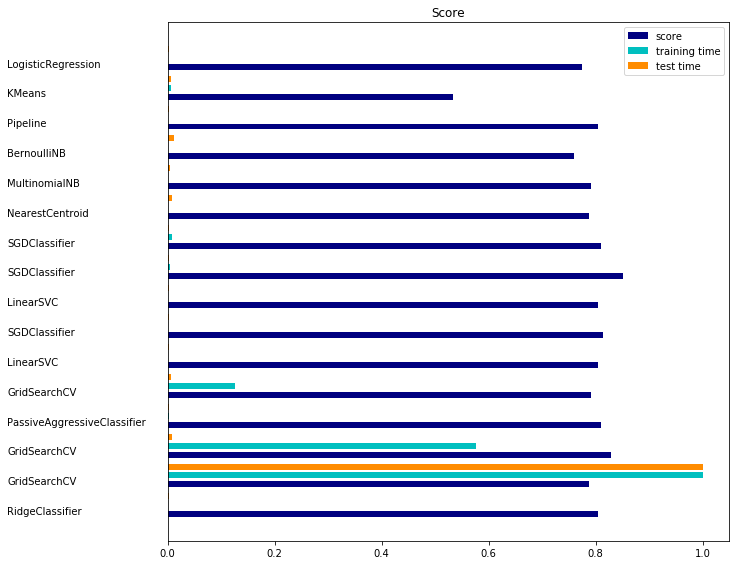

Evaluating Split 7
Train Size: 883
Test Size: 221
Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver=u'lsqr',
        tol=0.01)
train time: 0.185s
test time:  0.004s
accuracy:   0.805
dimensionality: 10158
density: 1.000000
()
classification report:
             precision    recall  f1-score   support

      infra       0.86      0.70      0.77       105
       user       0.77      0.90      0.83       116

avg / total       0.81      0.81      0.80       221

confusion matrix:
[[ 74  31]
 [ 12 104]]
()
gridsearchknn
________________________________________________________________________________
Training: 
GridSearchCV(cv=10, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbor

/nfs/site/home/kputtas1/instance/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 1.199s
test time:  0.003s
accuracy:   0.824
dimensionality: 10158
density: 0.983068
()
classification report:
             precision    recall  f1-score   support

      infra       0.92      0.69      0.79       105
       user       0.77      0.95      0.85       116

avg / total       0.84      0.82      0.82       221

confusion matrix:
[[ 72  33]
 [  6 110]]
()
gridsearchRF
________________________________________________________________________________
Training: 
GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, 

/nfs/site/home/kputtas1/instance/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.813s
test time:  0.003s
accuracy:   0.814
dimensionality: 10158
density: 0.986710
()
classification report:
             precision    recall  f1-score   support

      infra       0.88      0.70      0.78       105
       user       0.77      0.91      0.84       116

avg / total       0.82      0.81      0.81       221

confusion matrix:
[[ 74  31]
 [ 10 106]]
()
L1 penalty
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty=u'l1', random_state=None, tol=0.001,
     verbose=0)
train time: 0.068s
test time:  0.004s
accuracy:   0.756
dimensionality: 10158
density: 0.014176
()
classification report:
             precision    recall  f1-score   support

      infra       0.81      0.63      0.71       105
       user       0.72      0.87      0.79       116

avg / total      

/nfs/site/home/kputtas1/instance/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 2.898s
test time:  0.003s
accuracy:   0.833
dimensionality: 10158
density: 0.086828
()
classification report:
             precision    recall  f1-score   support

      infra       0.90      0.72      0.80       105
       user       0.79      0.93      0.85       116

avg / total       0.84      0.83      0.83       221

confusion matrix:
[[ 76  29]
 [  8 108]]
()
Elastic-Net penalty
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=50,
       n_jobs=1, penalty=u'elasticnet', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)


/nfs/site/home/kputtas1/instance/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 5.132s
test time:  0.003s
accuracy:   0.814
dimensionality: 10158
density: 0.510238
()
classification report:
             precision    recall  f1-score   support

      infra       0.92      0.67      0.77       105
       user       0.76      0.95      0.84       116

avg / total       0.84      0.81      0.81       221

confusion matrix:
[[ 70  35]
 [  6 110]]
()
NearestCentroid (aka Rocchio classifier)
________________________________________________________________________________
Training: 
NearestCentroid(metric='euclidean', shrink_threshold=None)
train time: 0.067s
test time:  0.014s
accuracy:   0.692
classification report:
             precision    recall  f1-score   support

      infra       0.68      0.67      0.67       105
       user       0.70      0.72      0.71       116

avg / total       0.69      0.69      0.69       221

confusion matrix:
[[70 35]
 [33 83]]
()
Naive Bayes
________________________________________________________________________________


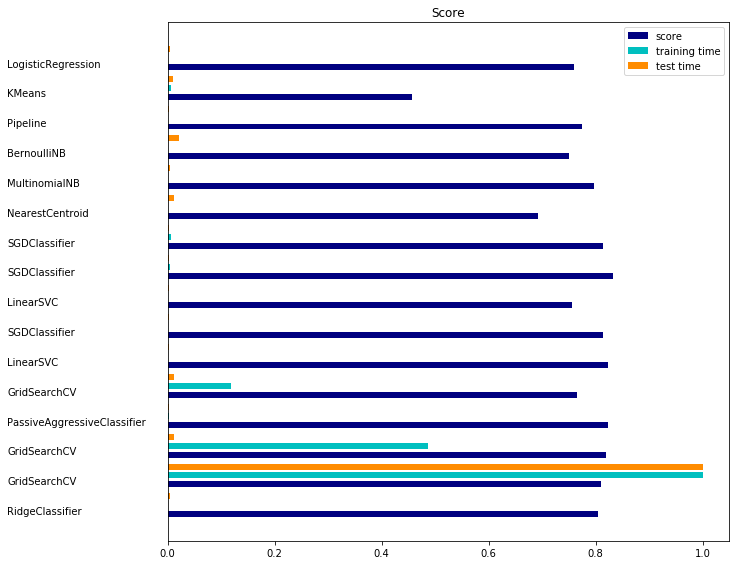

Evaluating Split 8
Train Size: 883
Test Size: 221
Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver=u'lsqr',
        tol=0.01)
train time: 0.183s
test time:  0.004s
accuracy:   0.851
dimensionality: 9985
density: 1.000000
()
classification report:
             precision    recall  f1-score   support

      infra       0.88      0.80      0.84       105
       user       0.83      0.90      0.86       116

avg / total       0.85      0.85      0.85       221

confusion matrix:
[[ 84  21]
 [ 12 104]]
()
gridsearchknn
________________________________________________________________________________
Training: 
GridSearchCV(cv=10, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors

/nfs/site/home/kputtas1/instance/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 1.188s
test time:  0.004s
accuracy:   0.855
dimensionality: 9985
density: 0.993090
()
classification report:
             precision    recall  f1-score   support

      infra       0.80      0.93      0.86       105
       user       0.93      0.78      0.85       116

avg / total       0.87      0.86      0.85       221

confusion matrix:
[[98  7]
 [25 91]]
()
gridsearchRF
________________________________________________________________________________
Training: 
GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_job

/nfs/site/home/kputtas1/instance/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.793s
test time:  0.004s
accuracy:   0.842
dimensionality: 9985
density: 0.985078
()
classification report:
             precision    recall  f1-score   support

      infra       0.78      0.93      0.85       105
       user       0.93      0.76      0.83       116

avg / total       0.86      0.84      0.84       221

confusion matrix:
[[98  7]
 [28 88]]
()
L1 penalty
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty=u'l1', random_state=None, tol=0.001,
     verbose=0)
train time: 0.063s
test time:  0.004s
accuracy:   0.796
dimensionality: 9985
density: 0.016024
()
classification report:
             precision    recall  f1-score   support

      infra       0.85      0.70      0.76       105
       user       0.76      0.89      0.82       116

avg / total       0.80 

/nfs/site/home/kputtas1/instance/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 2.875s
test time:  0.004s
accuracy:   0.801
dimensionality: 9985
density: 0.087832
()
classification report:
             precision    recall  f1-score   support

      infra       0.87      0.69      0.77       105
       user       0.76      0.91      0.83       116

avg / total       0.81      0.80      0.80       221

confusion matrix:
[[ 72  33]
 [ 11 105]]
()
Elastic-Net penalty
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=50,
       n_jobs=1, penalty=u'elasticnet', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)


/nfs/site/home/kputtas1/instance/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 5.071s
test time:  0.004s
accuracy:   0.860
dimensionality: 9985
density: 0.534101
()
classification report:
             precision    recall  f1-score   support

      infra       0.88      0.82      0.85       105
       user       0.85      0.90      0.87       116

avg / total       0.86      0.86      0.86       221

confusion matrix:
[[ 86  19]
 [ 12 104]]
()
NearestCentroid (aka Rocchio classifier)
________________________________________________________________________________
Training: 
NearestCentroid(metric='euclidean', shrink_threshold=None)
train time: 0.038s
test time:  0.016s
accuracy:   0.765
classification report:
             precision    recall  f1-score   support

      infra       0.76      0.74      0.75       105
       user       0.77      0.78      0.78       116

avg / total       0.76      0.76      0.76       221

confusion matrix:
[[78 27]
 [25 91]]
()
Naive Bayes
________________________________________________________________________________
T

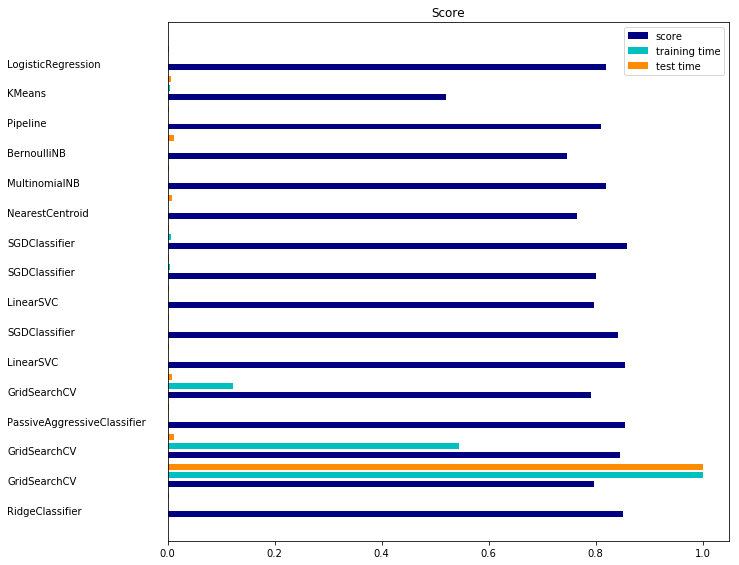

Evaluating Split 9
Train Size: 883
Test Size: 221
Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver=u'lsqr',
        tol=0.01)
train time: 0.175s
test time:  0.004s
accuracy:   0.801
dimensionality: 9498
density: 1.000000
()
classification report:
             precision    recall  f1-score   support

      infra       0.79      0.80      0.79       105
       user       0.82      0.80      0.81       116

avg / total       0.80      0.80      0.80       221

confusion matrix:
[[84 21]
 [23 93]]
()
gridsearchknn
________________________________________________________________________________
Training: 
GridSearchCV(cv=10, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, 

/nfs/site/home/kputtas1/instance/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 1.118s
test time:  0.004s
accuracy:   0.805
dimensionality: 9498
density: 0.994946
()
classification report:
             precision    recall  f1-score   support

      infra       0.79      0.80      0.80       105
       user       0.82      0.81      0.81       116

avg / total       0.81      0.81      0.81       221

confusion matrix:
[[84 21]
 [22 94]]
()
gridsearchRF
________________________________________________________________________________
Training: 
GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_job

/nfs/site/home/kputtas1/instance/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.743s
test time:  0.004s
accuracy:   0.842
dimensionality: 9498
density: 0.981996
()
classification report:
             precision    recall  f1-score   support

      infra       0.89      0.76      0.82       105
       user       0.81      0.91      0.86       116

avg / total       0.85      0.84      0.84       221

confusion matrix:
[[ 80  25]
 [ 10 106]]
()
L1 penalty
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty=u'l1', random_state=None, tol=0.001,
     verbose=0)
train time: 0.067s
test time:  0.004s
accuracy:   0.783
dimensionality: 9498
density: 0.016530
()
classification report:
             precision    recall  f1-score   support

      infra       0.78      0.75      0.77       105
       user       0.78      0.81      0.80       116

avg / total       0

/nfs/site/home/kputtas1/instance/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 2.782s
test time:  0.003s
accuracy:   0.778
dimensionality: 9498
density: 0.093493
()
classification report:
             precision    recall  f1-score   support

      infra       0.75      0.79      0.77       105
       user       0.80      0.77      0.78       116

avg / total       0.78      0.78      0.78       221

confusion matrix:
[[83 22]
 [27 89]]
()
Elastic-Net penalty
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=50,
       n_jobs=1, penalty=u'elasticnet', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)


/nfs/site/home/kputtas1/instance/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 4.769s
test time:  0.003s
accuracy:   0.796
dimensionality: 9498
density: 0.513477
()
classification report:
             precision    recall  f1-score   support

      infra       0.77      0.81      0.79       105
       user       0.82      0.78      0.80       116

avg / total       0.80      0.80      0.80       221

confusion matrix:
[[85 20]
 [25 91]]
()
NearestCentroid (aka Rocchio classifier)
________________________________________________________________________________
Training: 
NearestCentroid(metric='euclidean', shrink_threshold=None)
train time: 0.040s
test time:  0.014s
accuracy:   0.742
classification report:
             precision    recall  f1-score   support

      infra       0.72      0.75      0.73       105
       user       0.77      0.73      0.75       116

avg / total       0.74      0.74      0.74       221

confusion matrix:
[[79 26]
 [31 85]]
()
Naive Bayes
________________________________________________________________________________
Train

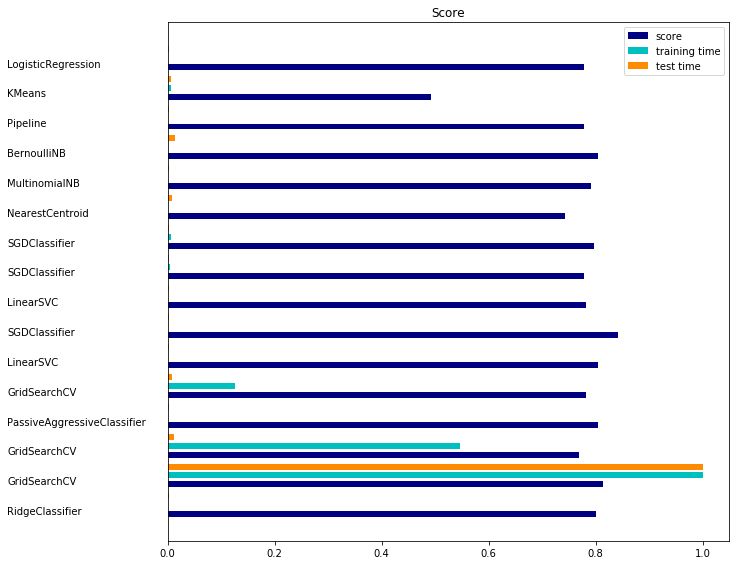

In [45]:
import matplotlib.pyplot as plt
for i_s, split in enumerate(splits):
    print("Evaluating Split {}".format(i_s))
    X_train, y_train, X_test, y_test, feature_names = get_X_andy_from_split(split)
    target_names = ["infra", "user"]
    print("Train Size: {}\nTest Size: {}".format(X_train.shape[0], X_test.shape[0]))
    results = []
    #alphas = np.array([1,0.1,0.01,0.001,0.0001,0])
    parameters_mlp={'hidden_layer_sizes':[(100,50),(300,100,50),(200,100)]}
    parameters_RF={ "n_estimators" : [50,60,70],
           "min_samples_leaf" : [1, 2]}
    k_range = list(range(1, 11))
    parameters_knn = {'n_neighbors':k_range}
    knn=KNeighborsClassifier(n_neighbors=5)
    for clf, name in [  
            (RidgeClassifier(tol=1e-2, solver="lsqr"), "Ridge Classifier"),
            (GridSearchCV(knn,parameters_knn, cv=10),"gridsearchknn"),
            #(Perceptron(n_iter=50), "Perceptron"),
            (GridSearchCV(MLPClassifier(activation='tanh'),parameters_mlp, cv=10),"gridsearchmlp"),
           # (MLPClassifier(hidden_layer_sizes=(100, 50), activation="logistic", max_iter=300), "MLP"),
            #(MLPClassifier(hidden_layer_sizes=(300, 100, 50), activation="logistic", max_iter=500), "MLP"),
           # (MLPClassifier(hidden_layer_sizes=(300, 100, 50), activation="tanh", max_iter=500), "MLP"),
            (PassiveAggressiveClassifier(n_iter=50), "Passive-Aggressive"),
           # (KNeighborsClassifier(n_neighbors=1), "kNN"),
           # (KNeighborsClassifier(n_neighbors=3), "kNN"),
           # (KNeighborsClassifier(n_neighbors=5), "kNN"),
            #(KNeighborsClassifier(n_neighbors=10), "kNN"),
            (GridSearchCV(RandomForestClassifier(n_estimators=10),parameters_RF, cv=10),"gridsearchRF")
            #(RandomForestClassifier(n_estimators=10), "Random forest"),
            #(RandomForestClassifier(n_estimators=50), "Random forest")
    ]:
           
        print('=' * 80)
        print(name)
        results.append(benchmark(clf, X_train, y_train, X_test, y_test, target_names,
                                 feature_names=feature_names))
       # print('parameters')
       # print(clf.grid_scores_[0])
        #print('CV Validation Score')
       # print(clf.grid_scores_[0].cv_validation_scores)
       # print('Mean Validation Score')
       # print(clf.grid_scores_[0].mean_validation_score)
       # grid_mean_scores = [result.mean_validation_score for result in clf.grid_scores_]
       # print(grid_mean_scores)
       # plt.plot(k_range, grid_mean_scores)
       # plt.xlabel('Value of K for KNN')
       # plt.ylabel('Cross-Validated Accuracy')

    #parameters_Linearsvc = [{'C': [1, 10], 'gamma': [0.1,1.0]}]
    for penalty in ["l2", "l1"]:
        print('=' * 80)
        print("%s penalty" % penalty.upper())
        # Train Liblinear model
        #grid=(GridSearchCV(LinearSVC,parameters_Linearsvc, cv=10),"gridsearchSVC")
        #results.append(benchmark(LinearSVC(penalty=penalty), X_train, y_train, X_test, y_test, target_names,
                                # feature_names=feature_names))
        results.append(benchmark(LinearSVC(penalty=penalty, dual=False,tol=1e-3),
                                 X_train, y_train, X_test, y_test, target_names,
                                 feature_names=feature_names))

        # Train SGD model
        results.append(benchmark(SGDClassifier(alpha=.0001, n_iter=50,
                                               penalty=penalty),
                                 X_train, y_train, X_test, y_test, target_names,
                                 feature_names=feature_names))

    # Train SGD with Elastic Net penalty
    print('=' * 80)
    print("Elastic-Net penalty")
    results.append(benchmark(SGDClassifier(alpha=.0001, n_iter=50,
                                           penalty="elasticnet"),
                             X_train, y_train, X_test, y_test, target_names,
                             feature_names=feature_names))

    # Train NearestCentroid without threshold
    print('=' * 80)
    print("NearestCentroid (aka Rocchio classifier)")
    results.append(benchmark(NearestCentroid(),
                             X_train, y_train, X_test, y_test, target_names,
                             feature_names=feature_names))

    # Train sparse Naive Bayes classifiers
    print('=' * 80)
    print("Naive Bayes")
    results.append(benchmark(MultinomialNB(alpha=.01),
                             X_train, y_train, X_test, y_test, target_names,
                             feature_names=feature_names))
    results.append(benchmark(BernoulliNB(alpha=.01),
                             X_train, y_train, X_test, y_test, target_names,
                             feature_names=feature_names))

    print('=' * 80)
    print("LinearSVC with L1-based feature selection")
    # The smaller C, the stronger the regularization.
    # The more regularization, the more sparsity.
    
# uncommenting more parameters will give better exploring power but will
# increase processing time in a combinatorial way
    results.append(benchmark(Pipeline([
                                  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False,
                                                                                  tol=1e-3))),
                                  ('classification', LinearSVC(penalty="l2"))]),
                             X_train, y_train, X_test, y_test, target_names,
                             feature_names=feature_names))
   # print(grid.grid_scores_)
   #KMeans clustering algorithm 
    print('=' * 80)
    print("KMeans")
    results.append(benchmark(KMeans(n_clusters=2, init='k-means++', max_iter=300,
                verbose=0, random_state=0, tol=1e-4),
                             X_train, y_train, X_test, y_test, target_names,
                             feature_names=feature_names))
    
   
    
    print('=' * 80)
    print("LogisticRegression")
    #kfold = model_selection.KFold(n_splits=2, random_state=0)
    #model = LinearDiscriminantAnalysis()
    results.append(benchmark(LogisticRegression(C=1.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
                             X_train, y_train, X_test, y_test, target_names,
                             feature_names=feature_names))
    
    plot_results(results)
    
    